I'm trying to better understand buffers. At the time I wrote the bulk of this, I thought it was contributing to model bloat.

Much of this was written by ChatGPT. I've tried to explain what's going on.

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Create two versions of the model: one that registers the buffer in the top-level of the module and another that registers it per block ("LR" for later registration).

In [8]:
def get_model_stats(model, model_name="model.pt", input_example=None, do_print=True):
    if do_print:
        print("=== Model Size Analysis ===")

    # 1. Save model to disk
    torch.save(model.state_dict(), model_name)
    size_disk = os.path.getsize(model_name) / (1024 ** 2)
    if do_print:
        print(f"[Disk] Saved model size: {size_disk:.2f} MB")

    # 2. Estimate size in RAM (CPU memory)
    def size_of_model_tensors(model):
        param_size = sum(p.numel() for p in model.parameters())
        buffer_size = sum(b.numel() for b in model.buffers())
        total = param_size + buffer_size
        return total * 4 / (1024 ** 2)  # assuming float32

    model_cpu = model.cpu()
    size_ram = size_of_model_tensors(model_cpu)
    if do_print:
        print(f"[RAM ] Estimated model tensor size: {size_ram:.2f} MB")

    # 3. Measure VRAM usage
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    model_gpu = model.cuda()
    
    # Optional: Run a forward pass
    if input_example is not None:
        input_example = input_example.cuda()
        with torch.no_grad():
            _ = model_gpu(input_example)

    allocated = torch.cuda.memory_allocated() / (1024 ** 2)
    peak = torch.cuda.max_memory_allocated() / (1024 ** 2)
    if do_print:
        print(f"[VRAM] Allocated memory: {allocated:.2f} MB")
        print(f"[VRAM] Peak memory usage: {peak:.2f} MB")

    return {
        "disk_mb": size_disk,
        "ram_mb": size_ram,
        "vram_allocated_mb": allocated,
        "vram_peak_mb": peak
    }

In [3]:
# Register buffer in top-level model
class Block(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x, laplacian):
        x = torch.matmul(laplacian, x)
        return F.relu(self.linear(x))

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks, lap):
        super().__init__()
        self.register_buffer("my_buffer", lap)  # Replace with real Laplacian

        blocks = [Block(input_dim if i == 0 else hidden_dim, hidden_dim)
                  for i in range(num_blocks - 1)]
        blocks.append(Block(hidden_dim, output_dim))
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        for block in self.blocks:
            x = block(x, self.my_buffer)
        return x

In [4]:
# Register buffer in blocks (LR = Late register)
class BlockLR(nn.Module):
    def __init__(self, in_dim, out_dim, lap):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.register_buffer("my_buffer", lap)  # Replace with real Laplacian

    def forward(self, x):
        x = torch.matmul(self.my_buffer, x)
        return F.relu(self.linear(x))

class ModelLR(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks, lap):
        super().__init__()
        self.buffer = lap

        blocks = [BlockLR(input_dim if i == 0 else hidden_dim, hidden_dim, self.buffer)
                  for i in range(num_blocks - 1)]
        blocks.append(BlockLR(hidden_dim, output_dim, self.buffer))
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

In [9]:
N_NODES = 1000
N_BLOCKS_LIST = [10, 20, 30, 40]
eb_vram_max = []
lb_vram_max = []

X = torch.randn(N_NODES, 128)
x = X.clone()
LAP = torch.eye(N_NODES)

for n_blocks in N_BLOCKS_LIST:
    model = Model(input_dim=128, hidden_dim=512, output_dim=256,
                     num_blocks=n_blocks, lap=LAP)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    lb_vram_max.append(res["vram_peak_mb"])

    model = ModelLR(input_dim=128, hidden_dim=512, output_dim=256,
                       num_blocks=n_blocks, lap=LAP)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    eb_vram_max.append(res["vram_peak_mb"])

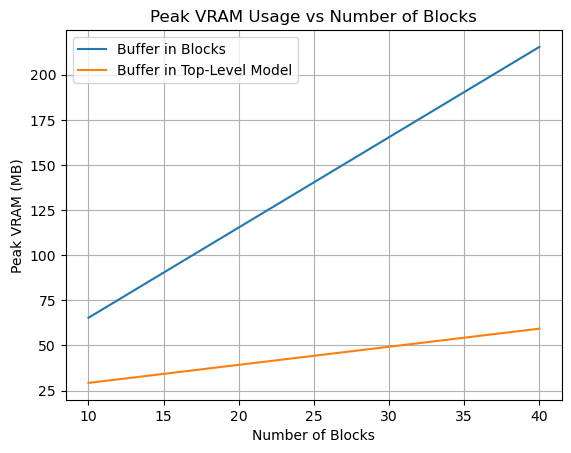

In [10]:
plt.plot(N_BLOCKS_LIST, eb_vram_max, label="Buffer in Blocks")
plt.plot(N_BLOCKS_LIST, lb_vram_max, label="Buffer in Top-Level Model")
plt.xlabel("Number of Blocks")
plt.ylabel("Peak VRAM (MB)")
plt.title("Peak VRAM Usage vs Number of Blocks")
plt.legend()
plt.grid()
plt.show()

In [11]:
N_BLOCKS = 10
N_NODES_LIST = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
eb_vram_max = []
lb_vram_max = []


for n_nodes in N_NODES_LIST:
    x = torch.randn(n_nodes, 128)
    lap = torch.eye(n_nodes)
    model = Model(input_dim=128, hidden_dim=512, output_dim=256,
                     num_blocks=N_BLOCKS, lap=lap)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    lb_vram_max.append(res["vram_peak_mb"])

    model = ModelLR(input_dim=128, hidden_dim=512, output_dim=256,
                       num_blocks=n_blocks, lap=lap)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    eb_vram_max.append(res["vram_peak_mb"])

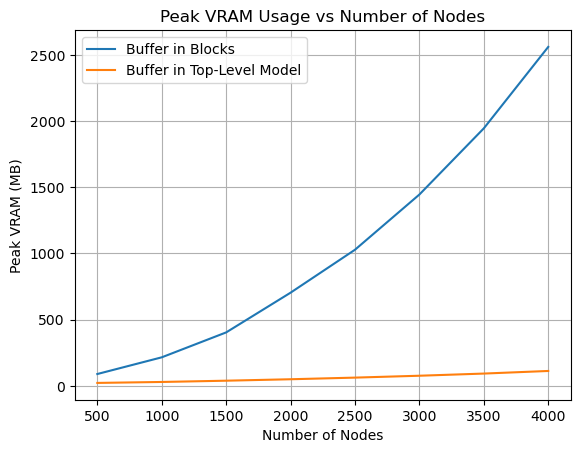

In [12]:
plt.plot(N_NODES_LIST, eb_vram_max, label="Buffer in Blocks")
plt.plot(N_NODES_LIST, lb_vram_max, label="Buffer in Top-Level Model")
plt.xlabel("Number of Nodes")
plt.ylabel("Peak VRAM (MB)")
plt.title("Peak VRAM Usage vs Number of Nodes")
plt.legend()
plt.grid()
plt.show()

# Repeated, with Sparse Matrices

In [ ]:
# Register buffer in top-level model
class BlockSparse(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x, laplacian):
        x = torch.sparse.mm(laplacian, x)
        return F.relu(self.linear(x))

class ModelSparse(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks, lap):
        super().__init__()
        self.register_buffer("my_buffer", lap)  # Replace with real Laplacian

        blocks = [BlockSparse(input_dim if i == 0 else hidden_dim, hidden_dim)
                  for i in range(num_blocks - 1)]
        blocks.append(BlockSparse(hidden_dim, output_dim))
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        for block in self.blocks:
            x = block(x, self.my_buffer)
        return x

# Register buffer in blocks (LR = Late register)
class BlockLRSparse(nn.Module):
    def __init__(self, in_dim, out_dim, lap):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.register_buffer("my_buffer", lap)  # Replace with real Laplacian

    def forward(self, x):
        x = torch.sparse.mm(self.my_buffer, x)
        return F.relu(self.linear(x))

class ModelLRSparse(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks, lap):
        super().__init__()
        self.buffer = lap

        blocks = [BlockLRSparse(input_dim if i == 0 else hidden_dim, hidden_dim, self.buffer)
                  for i in range(num_blocks - 1)]
        blocks.append(BlockLRSparse(hidden_dim, output_dim, self.buffer))
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x


# Register buffer, pass pointer
class BlockSparsePtr(nn.Module):
    def __init__(self, in_dim, out_dim, lap_ptr):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.lap = lap_ptr

    def forward(self, x):
        x = torch.sparse.mm(self.lap, x)
        return F.relu(self.linear(x))

class ModelSparsePtr(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks, lap):
        super().__init__()
        self.register_buffer("my_buffer", lap)  # Replace with real Laplacian

        blocks = [BlockSparse(input_dim if i == 0 else hidden_dim, hidden_dim)
                  for i in range(num_blocks - 1)]
        blocks.append(BlockSparse(hidden_dim, output_dim))
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        for block in self.blocks:
            x = block(x, self.my_buffer)
        return x


In [31]:
def make_random_sparse_laplacian(n_nodes, sparsity=0.01):
    n_edges = int(n_nodes**2 * sparsity)
    row = torch.randint(0, n_nodes, (n_edges,))
    col = torch.randint(0, n_nodes, (n_edges,))
    values = torch.randn(n_edges)
    indices = torch.stack([row, col])
    return torch.sparse_coo_tensor(indices, values, (n_nodes, n_nodes))

In [32]:
small_x_dense = torch.randn(100, 128)
lap = make_random_sparse_laplacian(100, sparsity=0.01)
small_x_sparse = torch.sparse.mm(lap, small_x_dense)

print("is sparse, small_x_dense:", small_x_dense.is_sparse)
print("is sparse, lap:", lap.is_sparse)
print("is sparse, small_x_sparse:", small_x_sparse.is_sparse)

# print("number non-zero elements, small_x_dense:", small_x_dense._nnz())
print("number of elements, lap:", lap.numel())
print("number non-zero elements, lap:", lap._nnz())
# print("number non-zero elements, small_x_sparse:", small_x_sparse._nnz())

is sparse, small_x_dense: False
is sparse, lap: True
is sparse, small_x_sparse: False
number of elements, lap: 10000
number non-zero elements, lap: 100


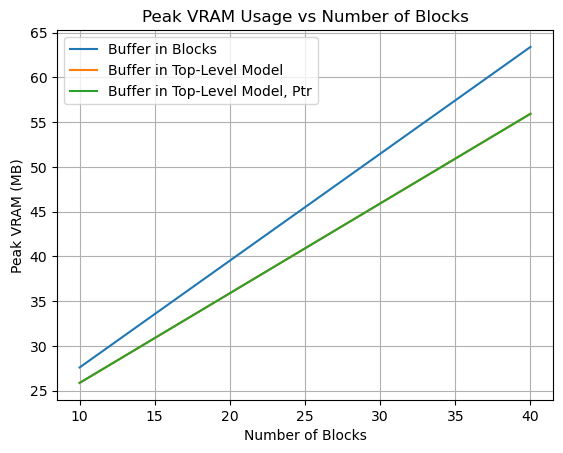

In [35]:
N_NODES = 1000
N_BLOCKS_LIST = [10, 20, 30, 40]
eb_vram_max = []
lb_vram_max = []
ptr_vram_max = []


LAP = make_random_sparse_laplacian(N_NODES, sparsity=0.01)
x = torch.randn(N_NODES, 128)

for n_blocks in N_BLOCKS_LIST:
    model = ModelSparse(input_dim=128, hidden_dim=512, output_dim=256,
                     num_blocks=n_blocks, lap=LAP)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    lb_vram_max.append(res["vram_peak_mb"])

    model = ModelLRSparse(input_dim=128, hidden_dim=512, output_dim=256,
                       num_blocks=n_blocks, lap=LAP)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    eb_vram_max.append(res["vram_peak_mb"])

    model = ModelSparsePtr(input_dim=128, hidden_dim=512, output_dim=256,
                       num_blocks=n_blocks, lap=LAP)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    ptr_vram_max.append(res["vram_peak_mb"])


plt.plot(N_BLOCKS_LIST, eb_vram_max, label="Buffer in Blocks")
plt.plot(N_BLOCKS_LIST, lb_vram_max, label="Buffer in Top-Level Model")
plt.plot(N_BLOCKS_LIST, ptr_vram_max, label="Buffer in Top-Level Model, Ptr")
plt.xlabel("Number of Blocks")
plt.ylabel("Peak VRAM (MB)")
plt.title("Peak VRAM Usage vs Number of Blocks")
plt.legend()
plt.grid()
plt.show()

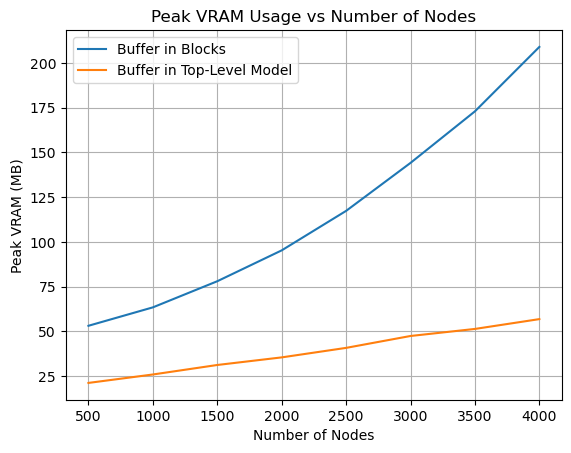

In [17]:
N_BLOCKS = 10
N_NODES_LIST = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
eb_vram_max = []
lb_vram_max = []


for n_nodes in N_NODES_LIST:
    lap = make_random_sparse_laplacian(n_nodes, sparsity=0.01)
    x = torch.randn(n_nodes, 128)
    model = Model(input_dim=128, hidden_dim=512, output_dim=256,
                     num_blocks=N_BLOCKS, lap=lap)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    lb_vram_max.append(res["vram_peak_mb"])

    model = ModelLR(input_dim=128, hidden_dim=512, output_dim=256,
                       num_blocks=n_blocks, lap=lap)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    eb_vram_max.append(res["vram_peak_mb"])

plt.plot(N_NODES_LIST, eb_vram_max, label="Buffer in Blocks")
plt.plot(N_NODES_LIST, lb_vram_max, label="Buffer in Top-Level Model")
plt.xlabel("Number of Nodes")
plt.ylabel("Peak VRAM (MB)")
plt.title("Peak VRAM Usage vs Number of Nodes")
plt.legend()
plt.grid()
plt.show()

# Question

How sparse is a Laplacian for a DeepSphere network?

In [ ]:
# import healpy as hp
# from deepsphere_unet.deepsphere.laplacian import (
#     healpix_graph,
#     prepare_laplacian,
#     scipy_csr_to_sparse_tensor
# )

In [ ]:
# NSIDE = 32
# G = healpix_graph(NSIDE, lap_type="combinatorial")
# G.compute_laplacian()
# lap = prepare_laplacian(G.L)
# # lap = scipy_csr_to_sparse_tensor(lap)

In [ ]:
# hp.nside2npix(NSIDE), lap.shape

(12288, torch.Size([12288, 12288]))

In [ ]:
# lap.numel(), lap.shape[0] * lap.shape[1]

(150994944, 150994944)

In [ ]:
# lap._nnz(), lap._nnz() / lap.numel()

(110568, 0.000732262929280599)

In [ ]:
# 8*NSIDE / (NSIDE**2)

0.25

# Storing local pointer

In [28]:
# Register buffer in top-level model
class BlockSparse(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x, laplacian):
        x = torch.sparse.mm(laplacian, x)
        return F.relu(self.linear(x))

class ModelSparse(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks, lap):
        super().__init__()
        self.register_buffer("my_buffer", lap)  # Replace with real Laplacian

        blocks = [BlockSparse(input_dim if i == 0 else hidden_dim, hidden_dim)
                  for i in range(num_blocks - 1)]
        blocks.append(BlockSparse(hidden_dim, output_dim))
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        for block in self.blocks:
            x = block(x, self.my_buffer)
        return x

# Register buffer in blocks (LR = Late register)
class BlockLRSparse(nn.Module):
    def __init__(self, in_dim, out_dim, lap):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.register_buffer("my_buffer", lap)  # Replace with real Laplacian

    def forward(self, x):
        x = torch.sparse.mm(self.my_buffer, x)
        return F.relu(self.linear(x))

class ModelLRSparse(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks, lap):
        super().__init__()
        self.buffer = lap

        blocks = [BlockLRSparse(input_dim if i == 0 else hidden_dim, hidden_dim, self.buffer)
                  for i in range(num_blocks - 1)]
        blocks.append(BlockLRSparse(hidden_dim, output_dim, self.buffer))
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

# Register buffer, pass pointer
class BlockSparsePtr(nn.Module):
    def __init__(self, in_dim, out_dim, lap_ptr):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.lap = lap_ptr

    def forward(self, x):
        x = torch.sparse.mm(self.lap, x)
        return F.relu(self.linear(x))

class ModelSparsePtr(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks, lap):
        super().__init__()
        self.register_buffer("my_buffer", lap)  # Replace with real Laplacian

        blocks = [BlockSparse(input_dim if i == 0 else hidden_dim, hidden_dim)
                  for i in range(num_blocks - 1)]
        blocks.append(BlockSparse(hidden_dim, output_dim))
        self.blocks = nn.ModuleList(blocks)

    def forward(self, x):
        for block in self.blocks:
            x = block(x, self.my_buffer)
        return x


ValueError: x and y must have same first dimension, but have shapes (4,) and (8,)

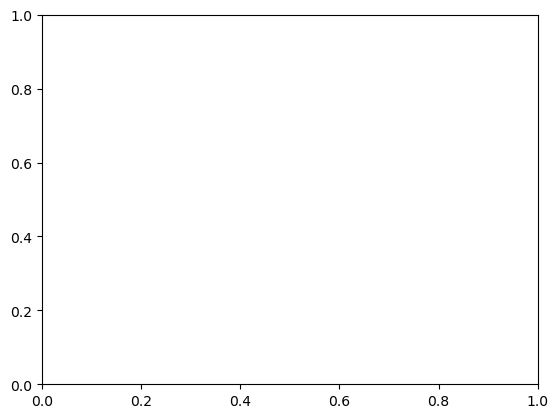

In [29]:
N_NODES = 1000
N_BLOCKS_LIST = [10, 20, 30, 40]
eb_vram_max = []
lb_vram_max = []

LAP = make_random_sparse_laplacian(N_NODES, sparsity=0.01)
x = torch.randn(N_NODES, 128)

for n_blocks in N_BLOCKS_LIST:
    model = ModelSparse(input_dim=128, hidden_dim=512, output_dim=256,
                     num_blocks=n_blocks, lap=LAP)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    lb_vram_max.append(res["vram_peak_mb"])

    model = ModelLRSparse(input_dim=128, hidden_dim=512, output_dim=256,
                       num_blocks=n_blocks, lap=LAP)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    eb_vram_max.append(res["vram_peak_mb"])

    model = ModelSparsePtr(input_dim=128, hidden_dim=512, output_dim=256,
                       num_blocks=n_blocks, lap=LAP)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    eb_vram_max.append(res["vram_peak_mb"])

plt.plot(N_BLOCKS_LIST, eb_vram_max, label="Buffer in Blocks")
plt.plot(N_BLOCKS_LIST, lb_vram_max, label="Buffer in Top-Level Model")
plt.xlabel("Number of Blocks")
plt.ylabel("Peak VRAM (MB)")
plt.title("Peak VRAM Usage vs Number of Blocks")
plt.legend()
plt.grid()
plt.show()

In [ ]:
N_BLOCKS = 10
N_NODES_LIST = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
eb_vram_max = []
lb_vram_max = []


for n_nodes in N_NODES_LIST:
    lap = make_random_sparse_laplacian(n_nodes, sparsity=0.01)
    x = torch.randn(n_nodes, 128)
    model = Model(input_dim=128, hidden_dim=512, output_dim=256,
                     num_blocks=N_BLOCKS, lap=lap)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    lb_vram_max.append(res["vram_peak_mb"])

    model = ModelLR(input_dim=128, hidden_dim=512, output_dim=256,
                       num_blocks=n_blocks, lap=lap)
    res = get_model_stats(model, model_name="big_model.pt", input_example=x, do_print=False)
    eb_vram_max.append(res["vram_peak_mb"])

plt.plot(N_NODES_LIST, eb_vram_max, label="Buffer in Blocks")
plt.plot(N_NODES_LIST, lb_vram_max, label="Buffer in Top-Level Model")
plt.xlabel("Number of Nodes")
plt.ylabel("Peak VRAM (MB)")
plt.title("Peak VRAM Usage vs Number of Nodes")
plt.legend()
plt.grid()
plt.show()